# Hate Speech Detector - PL - SVM model

Based on [this notebook](https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/classifier/final_classifier.ipynb).

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import pickle
from klepto.archives import dir_archive

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Load features & labels

In [2]:
archive = dir_archive('hsd/Poleval2019/X_y_svm', {}, cached=True)
archive.load()

features = archive['features']
labels = archive['labels']

In [3]:
features.shape

(11041, 416)

## Model

The best model was selected using a GridSearch with 5-fold CV.

In [4]:
# dimensions reduction
select = SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l1", C=0.01))
feat_ = select.fit_transform(features, labels)

/home/jakub/Dokumenty/VirtualEnv/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
# linear svm classifier
model = LinearSVC(class_weight='balanced', C=0.01, penalty='l2', loss='squared_hinge', multi_class='ovr').fit(feat_, labels)

/home/jakub/Dokumenty/VirtualEnv/local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [6]:
# logistic regression classifier
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.01).fit(feat_, labels)

In [7]:
# predictions
y_preds = model.predict(feat_)

## Visualizations

In [8]:
def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    plt.legend(labels=['Real', 'Predicted'], loc='best')
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [9]:
report = classification_report(labels, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     10056
           1       0.51      0.91      0.65       985

   micro avg       0.91      0.91      0.91     11041
   macro avg       0.75      0.91      0.80     11041
weighted avg       0.95      0.91      0.92     11041



In [10]:
classes = ['no hate', 'hate']
conf_mat = confusion_matrix(labels, y_preds)
conf_mat_perc = np.array([[round(float(it)/np.sum(row), 2) for it in row] for row in conf_mat])
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))

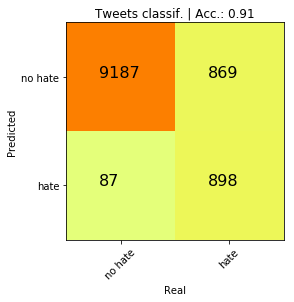

In [11]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Tweets classif. | Acc.: {}'.format(round(acc, 2)),
                      file_name='results/pl_svm/cm.png')

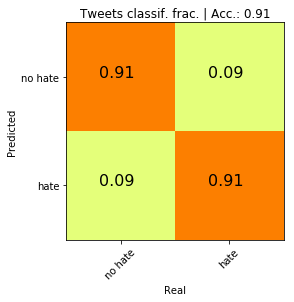

In [12]:
confusion_matrix_plot(conf_mat_perc, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Tweets classif. frac. | Acc.: {}'.format(round(acc, 2)),
                      file_name='results/pl_svm/frac_cm.png')

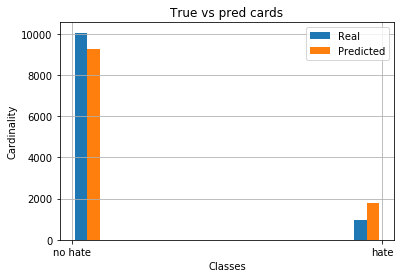

In [13]:
class_distribution_hist(labels, y_preds, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='True vs pred cards',
                        file_name='results/pl_svm/cards.png')

## Training with 70% & testing with 30%

In [14]:
X__train = feat_[:int(0.7*len(feat_))]
y_train = labels[:int(0.7*len(labels))]
X__test = feat_[int(0.7*len(feat_)):]
y_test = labels[int(0.7*len(labels)):]

print('Train X: {}'.format(len(X__train)))
print('Train y: {}'.format(len(y_train)))
print('Test X: {}'.format(len(X__test)))
print('Test y: {}'.format(len(y_test)))

Train X: 7728
Train y: 7728
Test X: 3313
Test y: 3313


In [15]:
# linear svm classifier
partial_model = LinearSVC(class_weight='balanced', C=0.01, penalty='l2', loss='squared_hinge', multi_class='ovr').fit(X__train, y_train)

In [16]:
# logistic regression classifier
partial_model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.01).fit(X__train,y_train)

In [17]:
# predictions
partial_y_preds = partial_model.predict(X__test)

## Visualizations

In [18]:
report = classification_report(y_test, partial_y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2806
           1       0.71      0.88      0.78       507

   micro avg       0.93      0.93      0.93      3313
   macro avg       0.84      0.91      0.87      3313
weighted avg       0.94      0.93      0.93      3313



In [19]:
part_conf_mat = confusion_matrix(y_test, partial_y_preds)
part_conf_mat_perc = np.array([[round(float(it)/np.sum(row), 2) for it in row] for row in part_conf_mat])
acc = float(np.sum(np.diag(part_conf_mat)))/np.sum(np.sum(part_conf_mat))

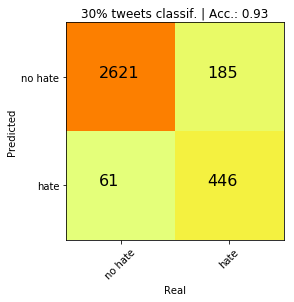

In [20]:
confusion_matrix_plot(part_conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='30% tweets classif. | Acc.: {}'.format(round(acc, 2)),
                      file_name='results/pl_svm/cm_30p.png')

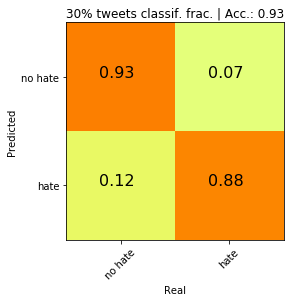

In [21]:
confusion_matrix_plot(part_conf_mat_perc, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='30% tweets classif. frac. | Acc.: {}'.format(round(acc, 2)),
                      file_name='results/pl_svm/frac_cm_30p.png')

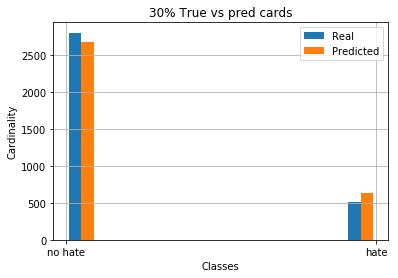

In [22]:
class_distribution_hist(y_test, partial_y_preds, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='30% True vs pred cards',
                        file_name='results/pl_svm/cards_30p.png')